In [193]:
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [194]:
# Cargar la hoja "Anual" del nuevo archivo
archivo_nuevo = "Informe histórico anual 2021_2022_2023.xlsx"
sheet_name = "Anual"

# Definir la cantidad de filas para cada tabla (ajustar si es necesario)
total_rows = {
    'sobretension': 2161,  # Ajustar según el tamaño real de la tabla
    'sobrecarga': 810,  
    'sobreintensidad': 158  
}

nrows_sobretension = total_rows['sobretension'] - 7 + 1
nrows_sobrecarga = total_rows['sobrecarga'] - 7 + 1
nrows_sobreintensidad = total_rows['sobreintensidad'] - 7 + 1

# Diccionario para almacenar los DataFrames
dataframes = {}

# Tabla de sobretensión
df_sobretension = pd.read_excel(
    archivo_nuevo, 
    sheet_name=sheet_name, 
    usecols="B:G", 
    skiprows=6,  # Saltar hasta la fila 7
    nrows=nrows_sobretension,
    header=0
)
dataframes["subestaciones_sobretension"] = df_sobretension

# Tabla de sobrecarga
df_sobrecarga = pd.read_excel(
    archivo_nuevo, 
    sheet_name=sheet_name, 
    usecols="I:R", 
    skiprows=6, 
    nrows=nrows_sobrecarga,
    header=0
)
dataframes["lineas_sobrecarga"] = df_sobrecarga

# Tabla de sobreintensidad
df_sobreintensidad = pd.read_excel(
    archivo_nuevo, 
    sheet_name=sheet_name, 
    usecols="T:AB", 
    skiprows=6, 
    nrows=nrows_sobreintensidad,
    header=0
)
dataframes["subestaciones_sobreintensidad"] = df_sobreintensidad

# Mostrar resultados
for key, df in dataframes.items():
    print(f"\n{key}")
    print(df.head())


subestaciones_sobretension
  Nudo PSSE Codificación Oficial Código BDI sobretensión     SUBESTACIÓN (*)  \
0     12015                  NaN                 1002:18   SE 400 kV ALMAZAN   
1     24195             FUE-ATP1                1002:248   SE 220 kV OLMEDIL   
2     14059                  NaN               1002:2428  SE 400 kV MANZARES   
3     11060                  NaN               1002:1088   SE 400 kV PENAGOS   
4     11008                  NaN               1002:2389  SE 400 kV SOLORZAN   

   Nº Horas con Tensión Superior a 420 / 240 kV  % de Horas  
0                                          3311    0.383351  
1                                          2444    0.282969  
2                                          2335    0.270349  
3                                          2306    0.266991  
4                                          1888    0.218594  

lineas_sobrecarga
    Códigos PSSE Codificación Oficial.1 Código BDI sobrecarga  \
0  23141-23160-1                   

In [195]:
# Lee la información de Circuito Salud
df_circuito_salud = pd.read_excel(
    "Circuito Salud Historico.xlsx",
    sheet_name="page",  # Ajusta según corresponda
    usecols=["Código BDI", "Edad Instalación"],  # Ajusta según columnas
    header=0
)

# Lee la información de Trafo Salud
df_trafo_salud = pd.read_excel(
    "Trafo Salud Historico.xlsx",
    sheet_name="page",  # Ajusta según corresponda
    usecols=["Código BDI", "Edad Efectiva"],  # Ajusta según columnas
    header=0
)

In [196]:
for key, df in dataframes.items():
    if key == "subestaciones_sobretension":
        # Cruce con Trafos usando "Código BDI sobretensión"
        df = df.merge(
            df_trafo_salud,
            left_on="Código BDI sobretensión",
            right_on="Código BDI",
            how="left"
        )
        # Eliminar la columna redundante del merge
        df = df.drop(columns=["Código BDI"])
        
    elif key == "subestaciones_sobreintensidad":
        # Cruce con Trafos usando "Código BDI sobreintensidad"
        df = df.merge(
            df_trafo_salud,
            left_on="Código BDI sobreintensidad",
            right_on="Código BDI",
            how="left"
        )
        # Eliminar la columna redundante
        df = df.drop(columns=["Código BDI"])
        
    elif key == "lineas_sobrecarga":
        # Cruce con Circuitos usando "Código BDI sobrecarga"
        df = df.merge(
            df_circuito_salud,
            left_on="Código BDI sobrecarga",
            right_on="Código BDI",
            how="left"
        )
        # Eliminar la columna redundante
        df = df.drop(columns=["Código BDI"])
    
    dataframes[key] = df

In [197]:
for key, df in dataframes.items():
    print(f"\nDataFrame '{key}' tras el merge:")
    print(df.head())


DataFrame 'subestaciones_sobretension' tras el merge:
  Nudo PSSE Codificación Oficial Código BDI sobretensión     SUBESTACIÓN (*)  \
0     12015                  NaN                 1002:18   SE 400 kV ALMAZAN   
1     24195             FUE-ATP1                1002:248   SE 220 kV OLMEDIL   
2     14059                  NaN               1002:2428  SE 400 kV MANZARES   
3     11060                  NaN               1002:1088   SE 400 kV PENAGOS   
4     11008                  NaN               1002:2389  SE 400 kV SOLORZAN   

   Nº Horas con Tensión Superior a 420 / 240 kV  % de Horas  Edad Efectiva  
0                                          3311    0.383351            NaN  
1                                          2444    0.282969            NaN  
2                                          2335    0.270349            NaN  
3                                          2306    0.266991            NaN  
4                                          1888    0.218594            NaN  

D

In [198]:
# Diccionario para almacenar los totales de Trafos y Circuitos
totales_lineas_sobrecarga = {}

for key, df in dataframes.items():
    if 'lineas_sobrecarga' in key and 'LÍNEA o ATP' in df.columns:
        # 🔹 Contar las filas que empiezan con "A" (Trafos)
        total_trafos = df['LÍNEA o ATP'].astype(str).str.startswith('A').sum()

        # 🔹 Contar las filas que empiezan con "L" (Circuitos)
        total_circuitos = df['LÍNEA o ATP'].astype(str).str.startswith('L').sum()

        # 🔹 Guardar en el diccionario
        totales_lineas_sobrecarga[key] = {'trafos': total_trafos, 'circuitos': total_circuitos}

        # 🔹 Imprimir los resultados
        print(f"📊 Totales para {key}:")
        print(f"   - 🔹 Trafos (A): {total_trafos}")
        print(f"   - 🔹 Circuitos (L): {total_circuitos}")

📊 Totales para lineas_sobrecarga:
   - 🔹 Trafos (A): 52
   - 🔹 Circuitos (L): 752


In [199]:
print("Claves presentes en 'dataframes':")
for key in dataframes.keys():
    print(f" - {key}")

Claves presentes en 'dataframes':
 - subestaciones_sobretension
 - lineas_sobrecarga
 - subestaciones_sobreintensidad


In [200]:
# YA
# Ajusta el nombre y la ruta del archivo según corresponda.
filename = "mant_dv_ot_dato_aviso_ya_2012_2023 rev1.xlsx"
sheet_name = "general"  # Cambia si la hoja se llama diferente

# Carga el archivo en un DataFrame
ya = pd.read_excel(filename, sheet_name=sheet_name)

# Visualiza las primeras filas para verificar la carga
print(ya.head())

     cod_aviso   Año cod_averia cod_causa  cod_repercusion  \
0  10001604606  2023       F014       NaN              1.0   
1  10001604607  2023       F014       NaN              1.0   
2  10001604608  2023       F014       NaN              1.0   
3  10001604609  2023       F014       NaN              1.0   
4  10001605925  2023       F014       NaN              1.0   

  cod_grupo_planificador         Filtro tipos de anomalías  
0                    DML  N - Perfil de catálogo no aplica  
1                    DML  N - Perfil de catálogo no aplica  
2                    DML  N - Perfil de catálogo no aplica  
3                    DML  N - Perfil de catálogo no aplica  
4                    DML  N - Perfil de catálogo no aplica  


In [201]:
print(len(ya))

1007229


In [202]:
# YA_S
# Carga el archivo de Excel con los datos de los fallos potencialmente ligados a condiciones de explotación
# Ajusta el nombre y la ruta del archivo según corresponda.
filename = "Análisis fallos potencialmente ligados a condiciones explotación.xlsx"
sheet_name = "Análisis"  # Cambia si la hoja se llama diferente

# Carga el archivo en un DataFrame
filtro_general = pd.read_excel(filename, sheet_name=sheet_name)

# Filtra las filas donde la columna 'APLICA FILTRO (S/N)' sea 'S'
filtro = filtro_general[filtro_general['APLICA FILTRO (S/N)'] == 'S']

# Muestra las primeras filas del DataFrame filtrado
print("\nDataFrame filtrado:")
print(filtro.head())


DataFrame filtrado:
      perfiles cod_averia        des_cod_averia cod_causa  \
1768  YAT-MQ00       DE30  Bajo nivel de aceite      DE21   
1769  YAT-MQ00       DE30  Bajo nivel de aceite      DE31   
1770  YAT-MQ00       DE30  Bajo nivel de aceite      DE31   
1771  YAT-MQ00       DE30  Bajo nivel de aceite      DE31   
1772  YAT-MQ00       DE30  Bajo nivel de aceite      DE31   

                                des_cod_causa  cod_repercusion  \
1768  Degradación juntas o mal montaje juntas              2.0   
1769                  Defecto nivel magnético              0.0   
1770                  Defecto nivel magnético              1.0   
1771                  Defecto nivel magnético              2.0   
1772                  Defecto nivel magnético              NaN   

     cod_grupo_planificador APLICA FILTRO (S/N)  
1768                    SAT                   S  
1769                    SAT                   S  
1770                    SAT                   S  
1771           

In [203]:
# Columnas que deben coincidir en ambos DataFrames
common_cols = ["cod_averia", "cod_causa", "cod_repercusion", "cod_grupo_planificador"]

# Opcional: asegurarnos de que no haya duplicados en "filtro" si solo interesa la existencia
filtro_unico = filtro[common_cols].drop_duplicates()

# Hacer un merge (inner) para quedarnos con los registros de 'ya' que tienen coincidencia en 'filtro'
ya_coincidentes = pd.merge(
    ya, 
    filtro_unico, 
    on=common_cols, 
    how="inner"  # inner=intersección: solo filas que matchean
)

print("Filas de ya que coinciden con filtro:", len(ya_coincidentes))
print(ya_coincidentes.head())

Filas de ya que coinciden con filtro: 1416
     cod_aviso   Año cod_averia cod_causa  cod_repercusion  \
0  10001489870  2021       F082       NaN              2.0   
1  10001489871  2021       F082       NaN              2.0   
2  10001489972  2021       F082       NaN              2.0   
3  10001490203  2021       F082       NaN              2.0   
4  10001491085  2021       F082       NaN              2.0   

  cod_grupo_planificador Filtro tipos de anomalías  
0                    DML                         S  
1                    DML                         S  
2                    DML                         S  
3                    DML                         S  
4                    DML                         S  


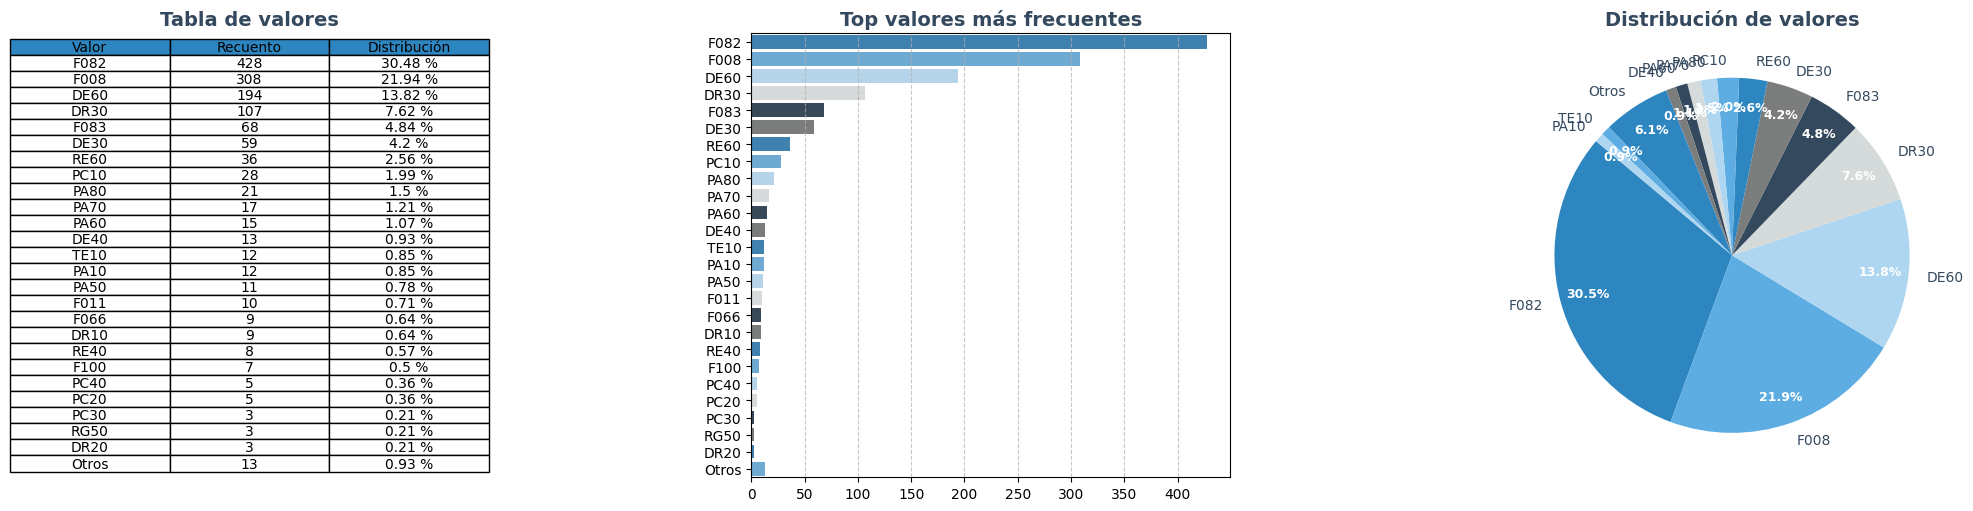

In [204]:
# Crear una tabla dinámica para mostrar el recuento de valores obtenidos tras el filtrado
# Aquí usamos la columna 'cod_averia' como ejemplo de análisis
pivot_table = ya_coincidentes.melt(value_vars=["cod_averia"]).value_counts().reset_index()
pivot_table.columns = ["Columna", "Valor", "Recuento"]

# Eliminar la columna "Columna"
pivot_table.drop(columns=["Columna"], inplace=True)

# Calcular la distribución porcentual
total_valores = pivot_table["Recuento"].sum()
pivot_table["Distribución"] = (pivot_table["Recuento"] / total_valores) * 100

# Umbral para definir valores poco frecuentes (ej. menos del 2% se agrupará en "Otros")
umbral = 2  

# Filtrar por Top 25, dejando solo los 25 valores más frecuentes
pivot_table_top_25 = pivot_table.nlargest(25, 'Recuento')

# Separar valores poco frecuentes (que no están en el Top 25)
otros = pivot_table[~pivot_table["Valor"].isin(pivot_table_top_25["Valor"])]

if not otros.empty:  # Si hay valores poco frecuentes
    otros_recuento = otros["Recuento"].sum()
    otros_distribucion = otros["Distribución"].sum()

    # Crear una fila "Otros"
    otros_fila = pd.DataFrame({
        "Valor": ["Otros"], 
        "Recuento": [otros_recuento], 
        "Distribución": [otros_distribucion]
    })

    # Filtrar el dataframe principal y agregar "Otros"
    pivot_table = pivot_table_top_25
    pivot_table = pd.concat([pivot_table, otros_fila], ignore_index=True)
else:
    pivot_table = pivot_table_top_25

# Asegurar que "Distribución" sea float y luego convertirla en porcentaje con 2 decimales
pivot_table["Distribución"] = pivot_table["Distribución"].astype(float).round(2)
pivot_table["Distribución"] = pivot_table["Distribución"].astype(str) + " %"

# Paleta de colores personalizada
custom_colors = ["#2E86C1", "#5DADE2", "#AED6F1", "#D5DBDB", "#34495E", "#7B7D7D"]

# Estilo de la tabla
styled_table = pivot_table.style.set_table_styles([
    {"selector": "thead th",
     "props": [("background-color", "#2E86C1"),
               ("color", "white"),
               ("font-weight", "bold"),
               ("text-align", "center")]},
    {"selector": "tbody td",
     "props": [("background-color", "#F2F3F4"),
               ("border", "1px solid #AAB7B8"),
               ("padding", "8px"),
               ("text-align", "center")]},
    {"selector": "tbody tr:nth-child(even)",
     "props": [("background-color", "#EAF2F8")]},
]).set_properties(**{
    "border": "1px solid #AAB7B8",
    "padding": "8px",
    "font-family": "Arial, sans-serif",
    "text-align": "center",
    "color": "#2E86C1",
}).hide(axis="index")

# Crear la figura con 3 subgráficos (1 fila, 3 columnas)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1) Tabla en el primer subgráfico
axes[0].axis("off")
axes[0].table(
    cellText=pivot_table.values,
    colLabels=pivot_table.columns,
    loc="center",
    cellLoc="center",
    colColours=["#2E86C1"] * len(pivot_table.columns)
)
axes[0].set_title("Tabla de valores", fontsize=14, fontweight="bold", color="#34495E")

# 2) Gráfico de Barras en el segundo subgráfico
sns.barplot(
    x="Recuento", y="Valor",
    data=pivot_table,
    palette=custom_colors[:len(pivot_table)],
    ax=axes[1]
)
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].set_title("Top valores más frecuentes", fontsize=14, fontweight="bold", color="#34495E")
axes[1].grid(axis="x", linestyle="--", alpha=0.7)

# Ajustar la posición del gráfico de barras para moverlo a la derecha
axes[1].set_position([0.45, 0.1, 0.3, 0.9])

# 3) Gráfico Circular (Torta/Pie) en el tercer subgráfico
# Filtrar solo el Top 15 y "Otros"
pivot_table_top_15 = pivot_table.nlargest(15, 'Recuento')
otros_recuento = pivot_table[~pivot_table["Valor"].isin(pivot_table_top_15["Valor"])]["Recuento"].sum()
# Sumar la cuenta de 'Otros' a la fila 'Otros' dentro de pivot_table_top_15
if "Otros" in pivot_table_top_15["Valor"].values:
    pivot_table_top_15.loc[pivot_table_top_15["Valor"] == "Otros", "Recuento"] += otros_recuento

colors = custom_colors[:len(pivot_table_top_15)]  

wedges, texts, autotexts = axes[2].pie(
    pivot_table_top_15["Recuento"],
    labels=pivot_table_top_15["Valor"],
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    textprops={"fontsize": 10, "color": "#34495E"}
)

# Cambiar color de los valores a blanco dentro del gráfico
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_fontweight("bold")

# Separar los valores más hacia afuera
for i, autotext in enumerate(autotexts):
    angle = (wedges[i].theta2 + wedges[i].theta1) / 2  # ángulo medio de la cuña
    x_offset = 1.4 * autotext.get_position()[0]
    y_offset = 1.4 * autotext.get_position()[1]
    autotext.set_position((x_offset, y_offset))

axes[2].set_title("Distribución de valores", fontsize=14, fontweight="bold", color="#34495E")

# Ajustar el espacio entre subgráficos y mostrar
plt.tight_layout()
plt.show()

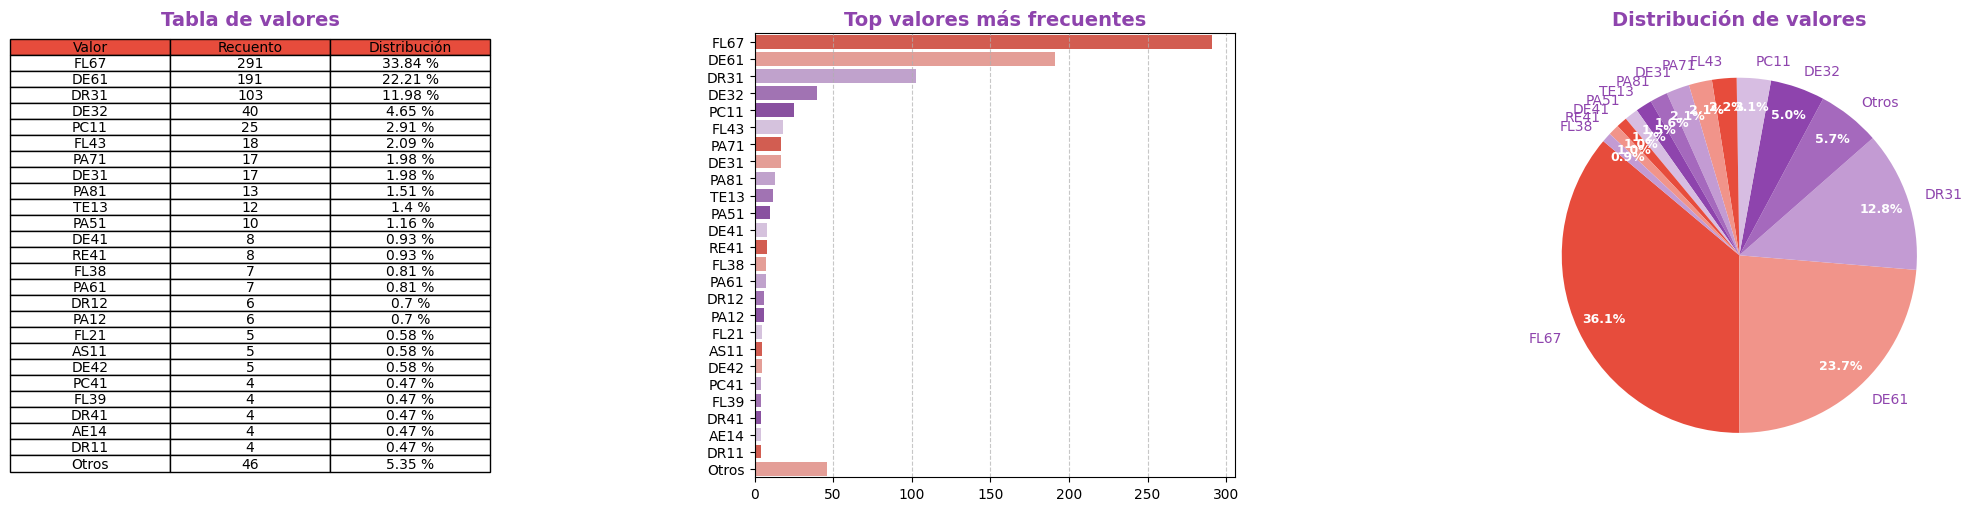

In [205]:
# Crear una tabla dinámica para mostrar el recuento de valores obtenidos tras el filtrado 
pivot_table = ya_coincidentes.melt(value_vars=["cod_causa"]).value_counts().reset_index()
pivot_table.columns = ["Columna", "Valor", "Recuento"]

# Eliminar la columna "Columna" (solo dejamos "Valor", "Recuento" y "Distribución")
pivot_table.drop(columns=["Columna"], inplace=True)

# Calcular la distribución porcentual
total_valores = pivot_table["Recuento"].sum()
pivot_table["Distribución"] = (pivot_table["Recuento"] / total_valores) * 100

# 📌 Umbral para definir valores poco frecuentes (menos del 2% se agrupará en "Otros")
umbral = 2  

# 🔹 Filtrar por Top 25, dejando solo los 25 valores más frecuentes
pivot_table_top_25 = pivot_table.nlargest(25, 'Recuento')

# Separar valores poco frecuentes (que no están en el Top 25)
otros = pivot_table[~pivot_table["Valor"].isin(pivot_table_top_25["Valor"])]

if not otros.empty:  # Si hay valores poco frecuentes
    otros_recuento = otros["Recuento"].sum()
    otros_distribucion = otros["Distribución"].sum()

    # Crear una fila "Otros"
    otros_fila = pd.DataFrame({"Valor": ["Otros"], "Recuento": [otros_recuento], "Distribución": [otros_distribucion]})

    # Filtrar el dataframe principal y agregar "Otros"
    pivot_table = pivot_table_top_25
    pivot_table = pd.concat([pivot_table, otros_fila], ignore_index=True)

# 🔹 Asegurar que "Distribución" siempre es float antes de convertirla en str
pivot_table["Distribución"] = pivot_table["Distribución"].astype(float).round(2)
pivot_table["Distribución"] = pivot_table["Distribución"].astype(str) + " %"

# 🎨 Paleta de colores personalizada (tonos rojos, rosas y morados)
custom_colors = ["#E74C3C", "#F1948A", "#C39BD3", "#A569BD", "#8E44AD", "#D7BDE2"]

# 📊 Estilo de la tabla con la tipografía y color igual al gráfico de barras
styled_table = pivot_table.style.set_table_styles([
    {"selector": "thead th", "props": [("background-color", "#E74C3C"), ("color", "white"), ("font-weight", "bold"), ("text-align", "center")]},
    {"selector": "tbody td", "props": [("background-color", "#F2F3F4"), ("border", "1px solid #AAB7B8"), ("padding", "8px"), ("text-align", "center")]},
    {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#FADBD8")]},
]).set_properties(**{
    "border": "1px solid #AAB7B8",
    "padding": "8px",
    "font-family": "Arial, sans-serif",
    "text-align": "center",
    "color": "#8E44AD",  # Color de la fuente igual al gráfico de barras
}).hide(axis="index")

# 📊 Configuración para mostrar los tres gráficos de forma horizontal
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 fila, 3 columnas

# Mostrar la tabla en el primer gráfico
# Para mostrar la tabla en el primer subgráfico, usamos `axes[0].axis("off")` y mostramos la tabla con `styled_table.render()`
axes[0].axis("off")
axes[0].table(cellText=pivot_table.values, colLabels=pivot_table.columns, loc="center", cellLoc="center", colColours=["#E74C3C"]*len(pivot_table.columns))
axes[0].set_title("Tabla de valores", fontsize=14, fontweight="bold", color="#8E44AD")

# 📊 Gráfico de Barras en el segundo subgráfico
sns.barplot(x="Recuento", y="Valor", data=pivot_table, palette=custom_colors[:len(pivot_table)], ax=axes[1])
axes[1].set_xlabel("")  # Eliminar la etiqueta del eje X
axes[1].set_ylabel("")  # Eliminar la etiqueta del eje Y
axes[1].set_title("Top valores más frecuentes", fontsize=14, fontweight="bold", color="#8E44AD")
axes[1].grid(axis="x", linestyle="--", alpha=0.7)

# Ajustar la posición del gráfico de barras para moverlo a la derecha
axes[1].set_position([0.45, 0.1, 0.3, 0.9])  # Cambiar la posición del gráfico de barras

# 📊 Gráfico Circular (Torta/Pie) en el tercer subgráfico
# Filtrar solo el Top 15 y "Otros"
pivot_table_top_15 = pivot_table.nlargest(15, 'Recuento')
otros_recuento = pivot_table[~pivot_table["Valor"].isin(pivot_table_top_15["Valor"])]["Recuento"].sum()
pivot_table_top_15.loc[pivot_table_top_15["Valor"] == "Recuento"] += otros_recuento

colors = custom_colors[:len(pivot_table_top_15)]  

# Gráfico Circular con valores en color blanco y ajustados más hacia afuera
wedges, texts, autotexts = axes[2].pie(pivot_table_top_15["Recuento"], labels=pivot_table_top_15["Valor"], autopct='%1.1f%%', colors=colors, startangle=140, textprops={"fontsize": 10, "color": "#8E44AD"})

# Cambiar el color solo de los valores dentro del gráfico a blanco
for autotext in autotexts:
    autotext.set_color('white')  # Establecer color blanco solo para los valores dentro del gráfico
    autotext.set_fontsize(9)  # Aumentar tamaño de fuente (opcional)
    autotext.set_fontweight("bold")

# Mover los valores más hacia el exterior (más alejados del centro)
for i, autotext in enumerate(autotexts):
    # Ajustar la posición del texto desplazándolo radialmente (más lejos del centro)
    angle = (wedges[i].theta2 + wedges[i].theta1) / 2  # Calcular el ángulo medio de cada cuña
    x_offset = 1.4 * autotext.get_position()[0]  # Ajustar el desplazamiento en X
    y_offset = 1.4 * autotext.get_position()[1]  # Ajustar el desplazamiento en Y
    autotext.set_position((x_offset, y_offset))  # Aplicar el desplazamiento

# Título del gráfico circular con el mismo color que antes
axes[2].set_title("Distribución de valores", fontsize=14, fontweight="bold", color="#8E44AD")

# Mostrar los gráficos
plt.tight_layout()  # Para ajustar el espacio entre los gráficos
plt.show()

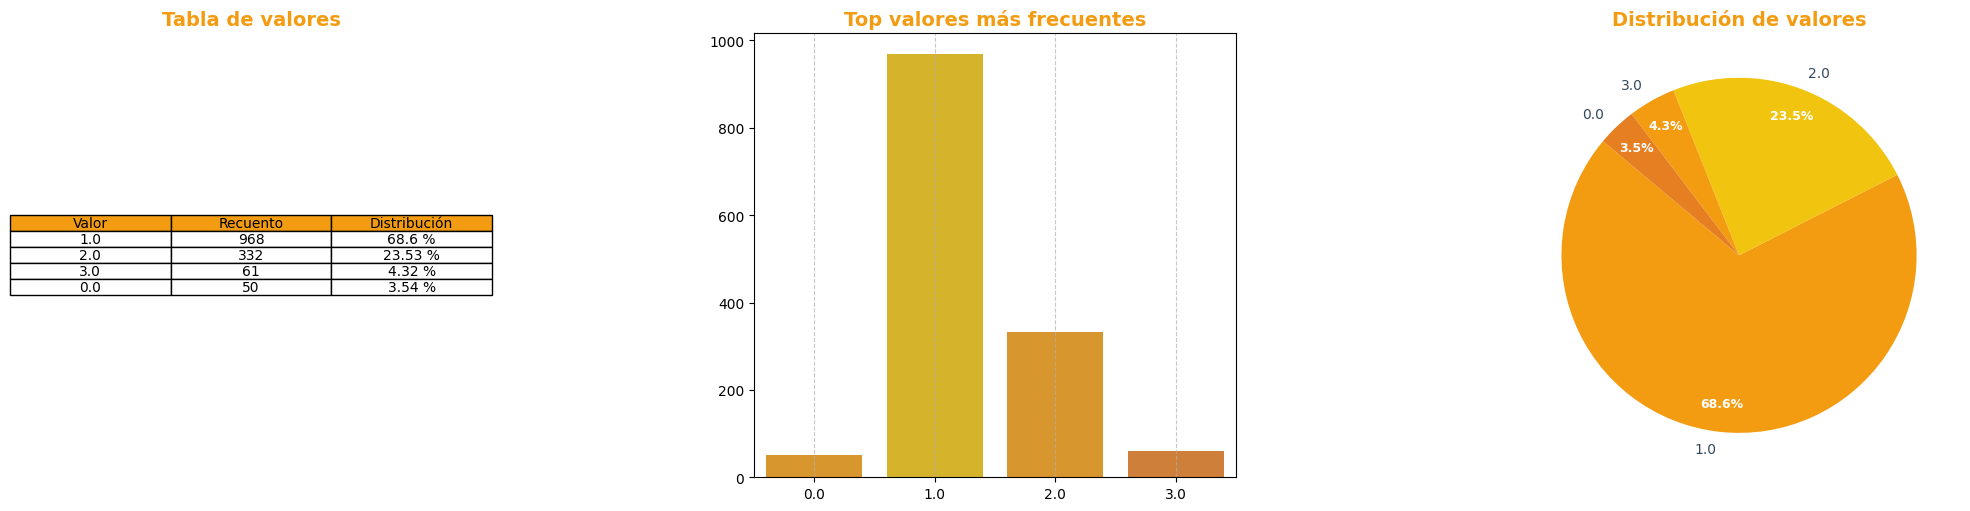

In [206]:
# Crear una tabla dinámica para mostrar el recuento de valores obtenidos tras el filtrado 
pivot_table = ya_coincidentes.melt(value_vars=["cod_repercusion"]).value_counts().reset_index()
pivot_table.columns = ["Columna", "Valor", "Recuento"]

# Eliminar la columna "Columna" (solo dejamos "Valor", "Recuento" y "Distribución")
pivot_table.drop(columns=["Columna"], inplace=True)

# Calcular la distribución porcentual
total_valores = pivot_table["Recuento"].sum()
pivot_table["Distribución"] = (pivot_table["Recuento"] / total_valores) * 100

# 📌 Umbral para definir valores poco frecuentes (menos del 2% se agrupará en "Otros")
umbral = 2  

# 🔹 Filtrar por Top 25, dejando solo los 25 valores más frecuentes
pivot_table_top_25 = pivot_table.nlargest(25, 'Recuento')

# Separar valores poco frecuentes (que no están en el Top 25)
otros = pivot_table[~pivot_table["Valor"].isin(pivot_table_top_25["Valor"])]

if not otros.empty:  # Si hay valores poco frecuentes
    otros_recuento = otros["Recuento"].sum()
    otros_distribucion = otros["Distribución"].sum()

    # Crear una fila "Otros"
    otros_fila = pd.DataFrame({"Valor": ["Otros"], "Recuento": [otros_recuento], "Distribución": [otros_distribucion]})

    # Filtrar el dataframe principal y agregar "Otros"
    pivot_table = pivot_table_top_25
    pivot_table = pd.concat([pivot_table, otros_fila], ignore_index=True)

# 🔹 Asegurar que "Distribución" siempre es float antes de convertirla en str
pivot_table["Distribución"] = pivot_table["Distribución"].astype(float).round(2)
pivot_table["Distribución"] = pivot_table["Distribución"].astype(str) + " %"

# 🎨 Paleta de colores personalizada (tonos cálidos: amarillos, anaranjados, dorados)
custom_colors = ["#F39C12", "#F1C40F", "#F39C12", "#E67E22", "#D35400", "#E74C3C", "#F5B041", "#F7DC6F", "#F9E79F", "#D68910"]

# 📊 Estilo de la tabla con la tipografía y color igual al gráfico de barras
styled_table = pivot_table.style.set_table_styles([
    {"selector": "thead th", "props": [("background-color", "#F39C12"), ("color", "white"), ("font-weight", "bold"), ("text-align", "center")]},
    {"selector": "tbody td", "props": [("background-color", "#F9E79F"), ("border", "1px solid #AAB7B8"), ("padding", "8px"), ("text-align", "center")]},
    {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#F7DC6F")]},
]).set_properties(**{
    "border": "1px solid #AAB7B8",
    "padding": "8px",
    "font-family": "Arial, sans-serif",
    "text-align": "center",
    "color": "#F39C12",  # Color de la fuente igual al gráfico de barras
}).hide(axis="index")

# 📊 Configuración para mostrar los tres gráficos de forma horizontal
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 fila, 3 columnas

# Mostrar la tabla en el primer gráfico
axes[0].axis("off")
axes[0].table(cellText=pivot_table.values, colLabels=pivot_table.columns, loc="center", cellLoc="center", colColours=["#F39C12"]*len(pivot_table.columns))
axes[0].set_title("Tabla de valores", fontsize=14, fontweight="bold", color="#F39C12")

# 📊 Gráfico de Barras en el segundo subgráfico
sns.barplot(x="Valor", y="Recuento", data=pivot_table, palette=custom_colors[:len(pivot_table)], ax=axes[1])
axes[1].set_xlabel("")  # Eliminar la etiqueta del eje X
axes[1].set_ylabel("")  # Eliminar la etiqueta del eje Y
axes[1].set_title("Top valores más frecuentes", fontsize=14, fontweight="bold", color="#F39C12")
axes[1].grid(axis="x", linestyle="--", alpha=0.7)

# Ajustar la posición del gráfico de barras para moverlo a la derecha
axes[1].set_position([0.45, 0.1, 0.3, 0.9])  # Cambiar la posición del gráfico de barras

# 📊 Gráfico Circular (Torta/Pie) en el tercer subgráfico
# Filtrar solo el Top 15 y "Otros"
pivot_table_top_15 = pivot_table.nlargest(15, 'Recuento')
otros_recuento = pivot_table[~pivot_table["Valor"].isin(pivot_table_top_15["Valor"])]["Recuento"].sum()
pivot_table_top_15.loc[pivot_table_top_15["Valor"] == "Otros", "Recuento"] += otros_recuento

colors = custom_colors[:len(pivot_table_top_15)]  

# Gráfico Circular con valores en color blanco y ajustados más hacia afuera
wedges, texts, autotexts = axes[2].pie(pivot_table_top_15["Recuento"], labels=pivot_table_top_15["Valor"], autopct='%1.1f%%', colors=colors, startangle=140, textprops={"fontsize": 10, "color": "#34495E"})

# Cambiar el color solo de los valores dentro del gráfico a blanco
for autotext in autotexts:
    autotext.set_color('white')  # Establecer color blanco solo para los valores dentro del gráfico
    autotext.set_fontsize(9)  # Aumentar tamaño de fuente (opcional)
    autotext.set_fontweight("bold")

# Mover los valores más hacia el exterior (más alejados del centro)
for i, autotext in enumerate(autotexts):
    # Ajustar la posición del texto desplazándolo radialmente (más lejos del centro)
    angle = (wedges[i].theta2 + wedges[i].theta1) / 2  # Calcular el ángulo medio de cada cuña
    x_offset = 1.4 * autotext.get_position()[0]  # Ajustar el desplazamiento en X
    y_offset = 1.4 * autotext.get_position()[1]  # Ajustar el desplazamiento en Y
    autotext.set_position((x_offset, y_offset))  # Aplicar el desplazamiento

# Título del gráfico circular con el mismo color que antes
axes[2].set_title("Distribución de valores", fontsize=14, fontweight="bold", color="#F39C12")

# Mostrar los gráficos
plt.tight_layout()  # Para ajustar el espacio entre los gráficos
plt.show()

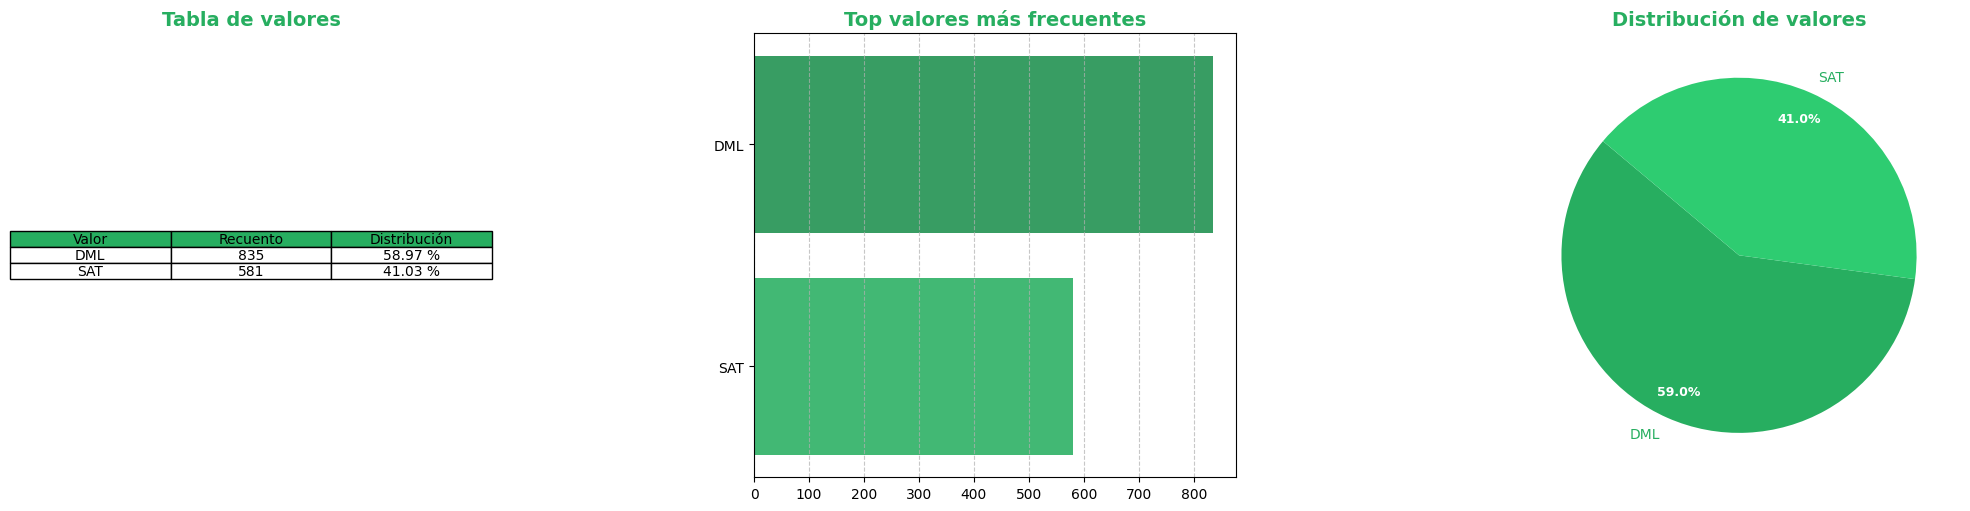

In [207]:
# Crear una tabla dinámica para mostrar el recuento de valores obtenidos tras el filtrado 
pivot_table = ya_coincidentes.melt(value_vars=["cod_grupo_planificador"]).value_counts().reset_index()
pivot_table.columns = ["Columna", "Valor", "Recuento"]

# Eliminar la columna "Columna" (solo dejamos "Valor", "Recuento" y "Distribución")
pivot_table.drop(columns=["Columna"], inplace=True)

# Calcular la distribución porcentual
total_valores = pivot_table["Recuento"].sum()
pivot_table["Distribución"] = (pivot_table["Recuento"] / total_valores) * 100

# 📌 Umbral para definir valores poco frecuentes (menos del 2% se agrupará en "Otros")
umbral = 2  

# 🔹 Filtrar por Top 25, dejando solo los 25 valores más frecuentes
pivot_table_top_25 = pivot_table.nlargest(25, 'Recuento')

# Separar valores poco frecuentes (que no están en el Top 25)
otros = pivot_table[~pivot_table["Valor"].isin(pivot_table_top_25["Valor"])]

if not otros.empty:  # Si hay valores poco frecuentes
    otros_recuento = otros["Recuento"].sum()
    otros_distribucion = otros["Distribución"].sum()

    # Crear una fila "Otros"
    otros_fila = pd.DataFrame({"Valor": ["Otros"], "Recuento": [otros_recuento], "Distribución": [otros_distribucion]})

    # Filtrar el dataframe principal y agregar "Otros"
    pivot_table = pivot_table_top_25
    pivot_table = pd.concat([pivot_table, otros_fila], ignore_index=True)

# 🔹 Asegurar que "Distribución" siempre es float antes de convertirla en str
pivot_table["Distribución"] = pivot_table["Distribución"].astype(float).round(2)
pivot_table["Distribución"] = pivot_table["Distribución"].astype(str) + " %"

# 🎨 Paleta de colores personalizada (tonalidades verdes)
custom_colors = ["#27AE60", "#2ECC71", "#58D68D", "#82E0AA", "#A9DFBF", "#7DCE3C", "#52D17E", "#45B39D", "#16A085", "#1D8348"]

# 📊 Estilo de la tabla con la tipografía y color igual al gráfico de barras
styled_table = pivot_table.style.set_table_styles([
    {"selector": "thead th", "props": [("background-color", "#27AE60"), ("color", "white"), ("font-weight", "bold"), ("text-align", "center")]},
    {"selector": "tbody td", "props": [("background-color", "#A9DFBF"), ("border", "1px solid #AAB7B8"), ("padding", "8px"), ("text-align", "center")]},
    {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#82E0AA")]},
]).set_properties(**{
    "border": "1px solid #AAB7B8",
    "padding": "8px",
    "font-family": "Arial, sans-serif",
    "text-align": "center",
    "color": "#27AE60",  # Color de la fuente igual al gráfico de barras
}).hide(axis="index")

# 📊 Configuración para mostrar los tres gráficos de forma horizontal
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 fila, 3 columnas

# Mostrar la tabla en el primer gráfico
axes[0].axis("off")
axes[0].table(cellText=pivot_table.values, colLabels=pivot_table.columns, loc="center", cellLoc="center", colColours=["#27AE60"]*len(pivot_table.columns))
axes[0].set_title("Tabla de valores", fontsize=14, fontweight="bold", color="#27AE60")  # Título en verde

# 📊 Gráfico de Barras en el segundo subgráfico
sns.barplot(x="Recuento", y="Valor", data=pivot_table, palette=custom_colors[:len(pivot_table)], ax=axes[1])
axes[1].set_xlabel("")  # Eliminar la etiqueta del eje X
axes[1].set_ylabel("")  # Eliminar la etiqueta del eje Y
axes[1].set_title("Top valores más frecuentes", fontsize=14, fontweight="bold", color="#27AE60")  # Título en verde
axes[1].grid(axis="x", linestyle="--", alpha=0.7)

# Ajustar la posición del gráfico de barras para moverlo a la derecha
axes[1].set_position([0.45, 0.1, 0.3, 0.9])  # Cambiar la posición del gráfico de barras

# 📊 Gráfico Circular (Torta/Pie) en el tercer subgráfico
# Filtrar solo el Top 15 y "Otros"
pivot_table_top_15 = pivot_table.nlargest(15, 'Recuento')
otros_recuento = pivot_table[~pivot_table["Valor"].isin(pivot_table_top_15["Valor"])]["Recuento"].sum()
pivot_table_top_15.loc[pivot_table_top_15["Valor"] == "Otros", "Recuento"] += otros_recuento

colors = custom_colors[:len(pivot_table_top_15)]  

# Gráfico Circular con valores en color blanco y ajustados más hacia afuera
wedges, texts, autotexts = axes[2].pie(pivot_table_top_15["Recuento"], labels=pivot_table_top_15["Valor"], autopct='%1.1f%%', colors=colors, startangle=140, textprops={"fontsize": 10, "color": "#27AE60"})  # Texto en verde

# Cambiar el color solo de los valores dentro del gráfico a blanco
for autotext in autotexts:
    autotext.set_color('white')  # Establecer color blanco solo para los valores dentro del gráfico
    autotext.set_fontsize(9)  # Aumentar tamaño de fuente (opcional)
    autotext.set_fontweight("bold")

# Mover los valores más hacia el exterior (más alejados del centro)
for i, autotext in enumerate(autotexts):
    # Ajustar la posición del texto desplazándolo radialmente (más lejos del centro)
    angle = (wedges[i].theta2 + wedges[i].theta1) / 2  # Calcular el ángulo medio de cada cuña
    x_offset = 1.4 * autotext.get_position()[0]  # Ajustar el desplazamiento en X
    y_offset = 1.4 * autotext.get_position()[1]  # Ajustar el desplazamiento en Y
    autotext.set_position((x_offset, y_offset))  # Aplicar el desplazamiento

# Título del gráfico circular con el mismo color que antes
axes[2].set_title("Distribución de valores", fontsize=14, fontweight="bold", color="#27AE60")  # Título en verde

# Mostrar los gráficos
plt.tight_layout()  # Para ajustar el espacio entre los gráficos
plt.show()

In [208]:
# Función para filtrar por Tipo de Fallo, Causa y Código de repercusión
def filtrar_dataframe(df, cod_averia="", cod_causa="", cod_repercusion="", cod_grupo_planificador=""):
    if cod_averia:  # Debe usar el argumento de la función
        df = df[df["cod_averia"] == cod_averia]
    if cod_causa:
        df = df[df["cod_causa"] == cod_causa]
    if cod_repercusion:
        df = df[df["cod_repercusion"] == cod_repercusion]
    if cod_grupo_planificador:  # Aquí se debe usar el parámetro correcto
        df = df[df["cod_grupo_planificador"] == cod_grupo_planificador]
    
    return df

# Solicitar valores al usuario
filtro_cod_averia = ""  # Puedes cambiar por input() si deseas preguntar al usuario
filtro_cod_causa = ""
filtro_cod_repercusion = ""
filtro_cod_grupo_planificador = ""

# Llamar a la función con los valores ingresados
resultado = filtrar_dataframe(ya_coincidentes, filtro_cod_averia, filtro_cod_causa, filtro_cod_repercusion, filtro_cod_grupo_planificador)

# Mostrar el DataFrame filtrado
print(resultado)

        cod_aviso   Año cod_averia cod_causa  cod_repercusion  \
0     10001489870  2021       F082       NaN              2.0   
1     10001489871  2021       F082       NaN              2.0   
2     10001489972  2021       F082       NaN              2.0   
3     10001490203  2021       F082       NaN              2.0   
4     10001491085  2021       F082       NaN              2.0   
...           ...   ...        ...       ...              ...   
1411  10001226051  2018       PA10      AS11              1.0   
1412  10001226052  2018       PA10      AS11              1.0   
1413  10001226053  2018       PA10      AS11              1.0   
1414  10001626321  2023       F092       NaN              3.0   
1415  10001585839  2023       F094       NaN              3.0   

     cod_grupo_planificador Filtro tipos de anomalías  
0                       DML                         S  
1                       DML                         S  
2                       DML                        

In [209]:
# Diccionario para almacenar los DataFrames filtrados
filtered_dataframes_filled_nuevo = {}

# Mapeo de columnas de BDI 
bdi_column_mapping_nuevo = {
    'subestaciones_sobretension': 'Código BDI sobretensión',
    'lineas_sobrecarga': 'Código BDI sobrecarga',
    'subestaciones_sobreintensidad': 'Código BDI sobreintensidad',
}

# Filtrar por las tablas del nuevo archivo
for key, df in dataframes.items():
    for tipo, columna_bdi in bdi_column_mapping_nuevo.items():
        if tipo in key and columna_bdi in df.columns:
            # Filtrar filas donde el Código BDI no sea NaN ni vacío
            df_filled = df[ 
                df[columna_bdi].notna() & 
                (df[columna_bdi].astype(str).str.strip() != '')
            ]
            filtered_dataframes_filled_nuevo[key] = df_filled

            # Imprimir cuántas filas con BDI relleno hay
            print(f"{key}: {len(df_filled)} filas con '{columna_bdi}' relleno (no NaN ni vacío)")
        
        # Mostrar algunas filas de las tablas filtradas para inspección
for key, df_filled in filtered_dataframes_filled_nuevo.items():
    print(f"\nPrimera muestra de la tabla filtrada (BDI relleno): {key}")
    print(df_filled.head())

subestaciones_sobretension: 1790 filas con 'Código BDI sobretensión' relleno (no NaN ni vacío)
lineas_sobrecarga: 541 filas con 'Código BDI sobrecarga' relleno (no NaN ni vacío)
subestaciones_sobreintensidad: 75 filas con 'Código BDI sobreintensidad' relleno (no NaN ni vacío)

Primera muestra de la tabla filtrada (BDI relleno): subestaciones_sobretension
  Nudo PSSE Codificación Oficial Código BDI sobretensión     SUBESTACIÓN (*)  \
0     12015                  NaN                 1002:18   SE 400 kV ALMAZAN   
1     24195             FUE-ATP1                1002:248   SE 220 kV OLMEDIL   
2     14059                  NaN               1002:2428  SE 400 kV MANZARES   
3     11060                  NaN               1002:1088   SE 400 kV PENAGOS   
4     11008                  NaN               1002:2389  SE 400 kV SOLORZAN   

   Nº Horas con Tensión Superior a 420 / 240 kV  % de Horas  Edad Efectiva  
0                                          3311    0.383351            NaN  
1       

In [210]:
# Avisos - Código BDI
filename3 = "AVISOS_BDI.csv"
sheet_name3 = "page"  # Cambia si la hoja se llama diferente

# Carga el archivo en un DataFrame
avisos_bdi = pd.read_csv(filename3)

# Dividir la columna "QMNUM;BDI" en dos columnas "QMNUM" y "BDI"
avisos_bdi[['QMNUM', 'BDI']] = avisos_bdi['QMNUM;BDI'].str.split(';', expand=True)

# Eliminar la columna original si ya no la necesitas
avisos_bdi.drop(columns=['QMNUM;BDI'], inplace=True)

avisos_bdi['QMNUM'] = pd.to_numeric(avisos_bdi['QMNUM'], errors='coerce')

# Visualiza las primeras filas para verificar la carga
print(avisos_bdi.head())

         QMNUM         BDI
0  10001369636  1004:17616
1  10001369497  1004:11997
2  10001369776  1004:13176
3  10001369778  1004:13182
4  10001369782  1004:13170


In [213]:
avisos_bdi = avisos_bdi.merge(
    resultado, 
    left_on='QMNUM',               # Nombre de la columna en df_subestaciones_sobretension
    right_on='cod_aviso',       # Nombre de la columna en maestro_bdi_bdi
    how='right'
)

# Eliminar la columna original si ya no la necesitas
avisos_bdi.drop(columns=['cod_aviso'], inplace=True)

avisos_bdi['Año'] = pd.to_numeric(avisos_bdi['Año'], errors='coerce').astype('Int64')

# Visualiza las primeras filas para verificar la carga
print(avisos_bdi.head())
print(len(avisos_bdi))

          QMNUM        BDI   Año cod_averia cod_causa  cod_repercusion  \
0  1.000149e+10  2019:2494  2021       F082       NaN              2.0   
1  1.000149e+10  2019:2495  2021       F082       NaN              2.0   
2  1.000149e+10  2019:2496  2021       F082       NaN              2.0   
3  1.000149e+10  2019:1874  2021       F082       NaN              2.0   
4  1.000149e+10  2019:7927  2021       F082       NaN              2.0   

  cod_grupo_planificador Filtro tipos de anomalías  
0                    DML                         S  
1                    DML                         S  
2                    DML                         S  
3                    DML                         S  
4                    DML                         S  
1416


In [214]:
# Agrupar por BDI 
anomalias_por_bdi = (
    avisos_bdi
    .groupby('BDI')
    .agg({'QMNUM': 'count'})
    .rename(columns={'QMNUM': 'num_anomalias'})
    .sort_values(by='num_anomalias', ascending=False)
)

# Imprimir las tablas para verificación
print("Anomalías por BDI del historico:")
print(anomalias_por_bdi)

Anomalías por BDI del historico:
            num_anomalias
BDI                      
1007:20:00             15
1006:1783               9
1006:385                8
1051:191                8
1006:84                 7
...                   ...
2019:1953               1
2019:1954               1
2019:1967               1
2019:1968               1
2122:99850              1

[1027 rows x 1 columns]


In [215]:
# Agrupar todas las anomalías 
anomalias_totales = (
    avisos_bdi
    .groupby('BDI')
    .agg({'QMNUM': 'count'})
    .rename(columns={'QMNUM': 'num_anomalias'})
    .reset_index()
)

# Asegurarse de que todos los DataFrames en filtered_dataframes_filled están actualizados
for key, df in filtered_dataframes_filled_nuevo.items():
    df_copy = df.copy()  # Trabajar con una copia para evitar SettingWithCopyWarning

    # Determinar la columna BDI correspondiente según el tipo de DataFrame
    if 'subestaciones_sobretension' in key:
        columna_bdi = 'Código BDI sobretensión'
    elif 'lineas_sobrecarga' in key:
        columna_bdi = 'Código BDI sobrecarga'
    elif 'subestaciones_sobreintensidad' in key:
        columna_bdi = 'Código BDI sobreintensidad'
    else:
        continue  # Si no corresponde, pasar al siguiente

    df_copy[columna_bdi] = df_copy[columna_bdi].astype(str)  # Convertir a string para el merge
    anomalias_totales['BDI'] = anomalias_totales['BDI'].astype(str)

    # Asegurarse de que 'num_anomalias' existe en anomalias_totales
    if 'num_anomalias' not in anomalias_totales.columns:
        anomalias_totales['num_anomalias'] = 0  # Asignar 0 si no existe

    # Realizar el merge sin filtrar por año
    df_con_anomalias = pd.merge(
        df_copy,
        anomalias_totales[['BDI', 'num_anomalias']],
        left_on=columna_bdi,
        right_on='BDI',
        how='left'
    )

    # Rellenar valores NaN de 'num_anomalias'
    df_con_anomalias['num_anomalias'] = df_con_anomalias['num_anomalias'].fillna(0).astype(float)
    
    # Actualizar el DataFrame en el diccionario
    filtered_dataframes_filled_nuevo[key] = df_con_anomalias.drop(columns=['BDI'], errors='ignore')  # Eliminar 'BDI' si se añadió

# Mostrar el resultado
for key, df in filtered_dataframes_filled_nuevo.items():
    print(f"DataFrame para {key} con anomalías:")
    print(df[['num_anomalias']].head(), '\n')  # Mostrar so

DataFrame para subestaciones_sobretension con anomalías:
   num_anomalias
0            0.0
1            0.0
2            0.0
3            0.0
4            0.0 

DataFrame para lineas_sobrecarga con anomalías:
   num_anomalias
0            1.0
1            1.0
2            0.0
3            0.0
4            0.0 

DataFrame para subestaciones_sobreintensidad con anomalías:
   num_anomalias
0            1.0
1            0.0
2            0.0
3            1.0
4            0.0 




🔹 Análisis de correlaciones histórico - subestaciones_sobretension (General)
 - 📊 Filas en el DataFrame original: 2154
 - 📊 Filas tras el filtrado: 1790
 - 📊 Porcentaje conservado: 83.10%


C:\Users\jsanzmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


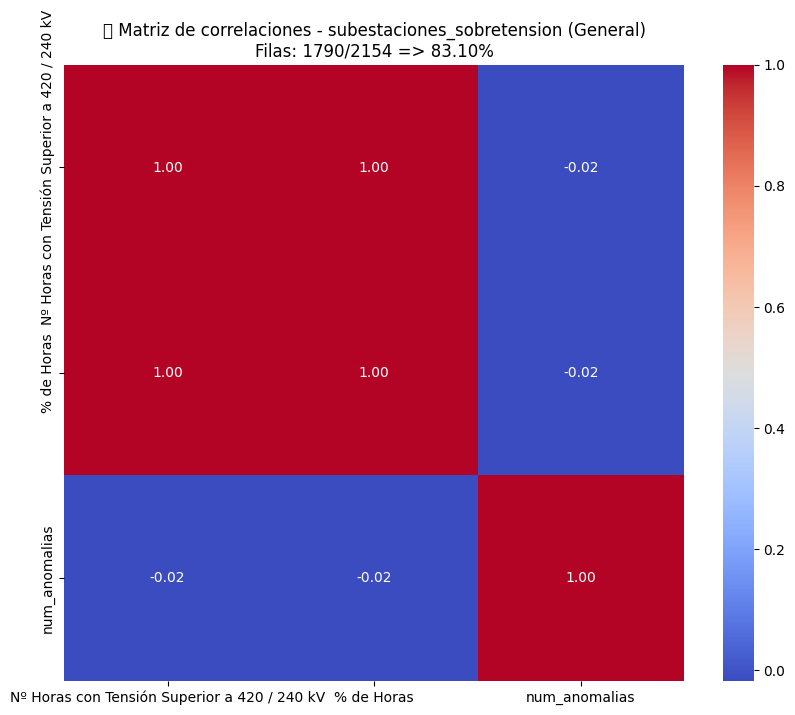

📈 Correlaciones con 'num_anomalias' para subestaciones - subestaciones_sobretension (General):
num_anomalias                                   1.000000
% de Horas                                     -0.017937
Nº Horas con Tensión Superior a 420 / 240 kV   -0.017955
Name: num_anomalias, dtype: float64

🔹 Análisis de correlaciones histórico - lineas_sobrecarga (Trafo)
 - 📊 Filas en el DataFrame original: 804
 - 📊 Filas tras el filtrado: 50
 - 📊 Porcentaje conservado: 6.22%


C:\Users\jsanzmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


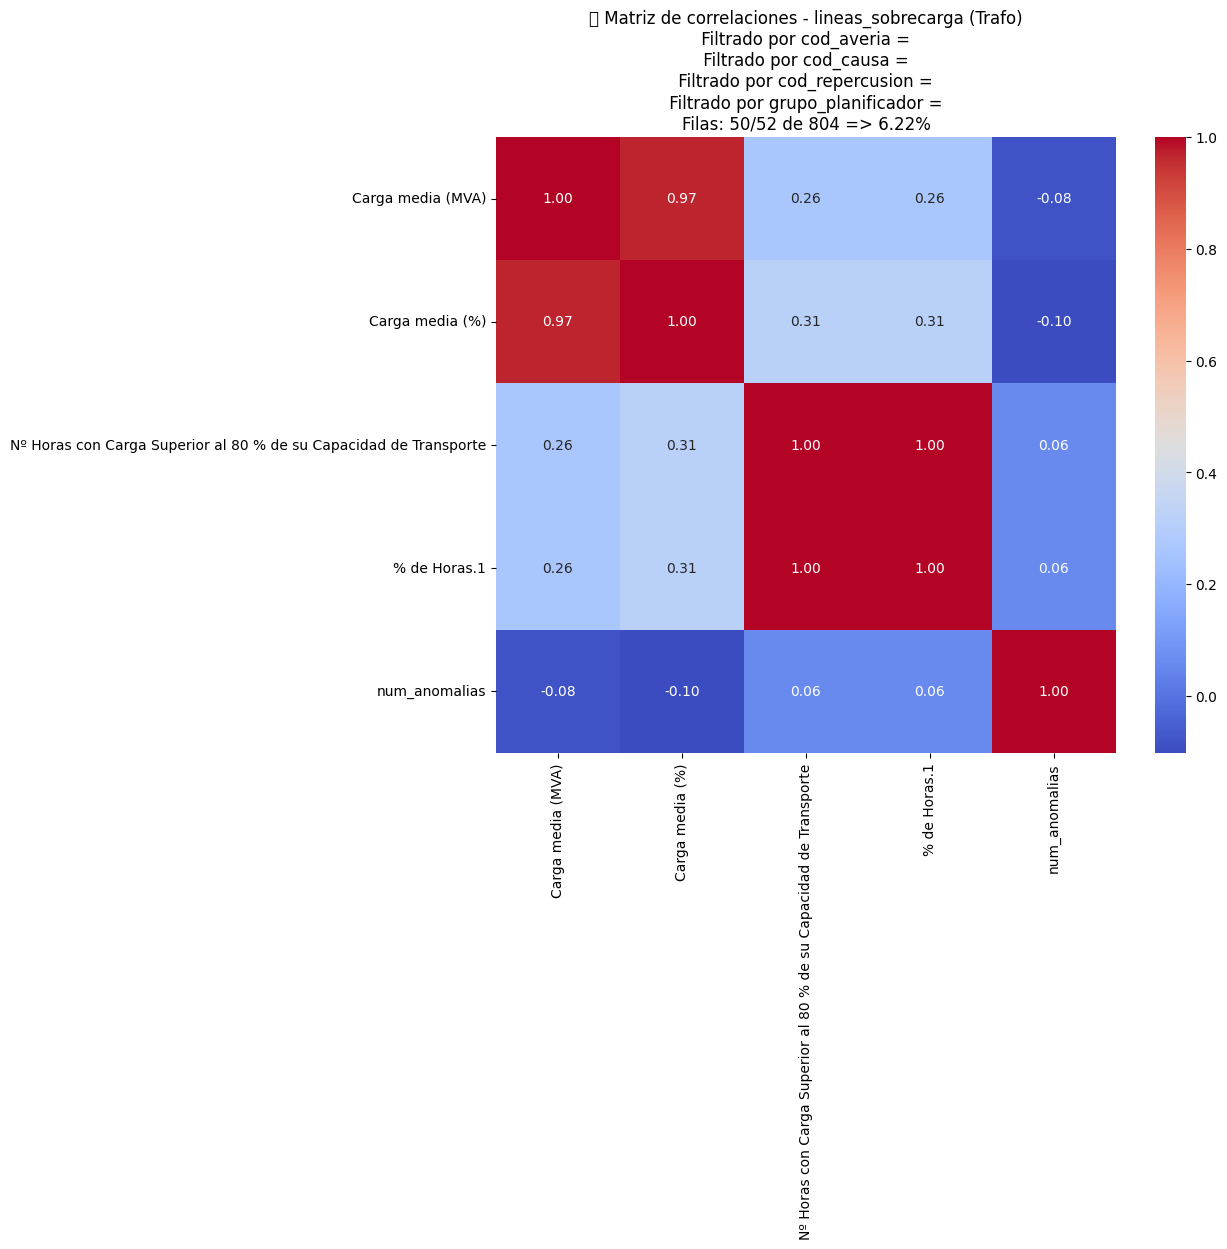

📈 Correlaciones con 'num_anomalias' para lineas - lineas_sobrecarga (Trafo):
num_anomalias                                                        1.000000
Nº Horas con Carga Superior al 80 % de su Capacidad de Transporte    0.058025
% de Horas.1                                                         0.057403
Carga media (MVA)                                                   -0.081112
Carga media (%)                                                     -0.101934
Name: num_anomalias, dtype: float64

🔹 Análisis de correlaciones histórico - lineas_sobrecarga (Circuito)
 - 📊 Filas en el DataFrame original: 804
 - 📊 Filas tras el filtrado: 491
 - 📊 Porcentaje conservado: 61.07%


C:\Users\jsanzmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


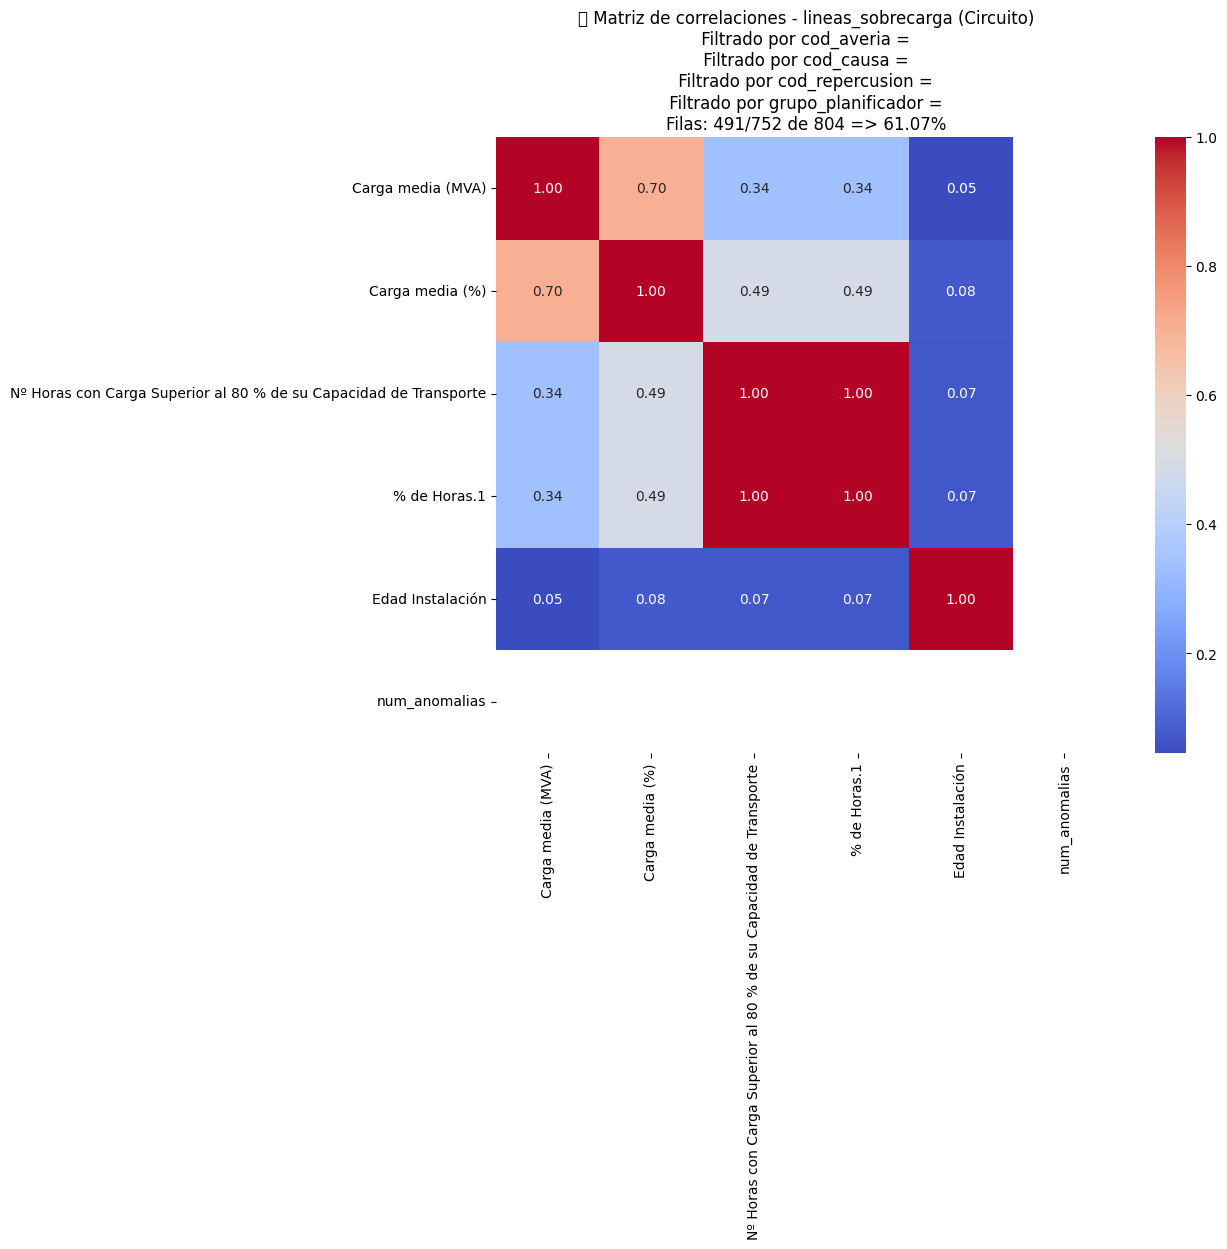

📈 Correlaciones con 'num_anomalias' para lineas - lineas_sobrecarga (Circuito):
Carga media (MVA)                                                   NaN
Carga media (%)                                                     NaN
Nº Horas con Carga Superior al 80 % de su Capacidad de Transporte   NaN
% de Horas.1                                                        NaN
Edad Instalación                                                    NaN
num_anomalias                                                       NaN
Name: num_anomalias, dtype: float64

🔹 Análisis de correlaciones histórico - subestaciones_sobreintensidad (General)
 - 📊 Filas en el DataFrame original: 152
 - 📊 Filas tras el filtrado: 75
 - 📊 Porcentaje conservado: 49.34%


C:\Users\jsanzmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


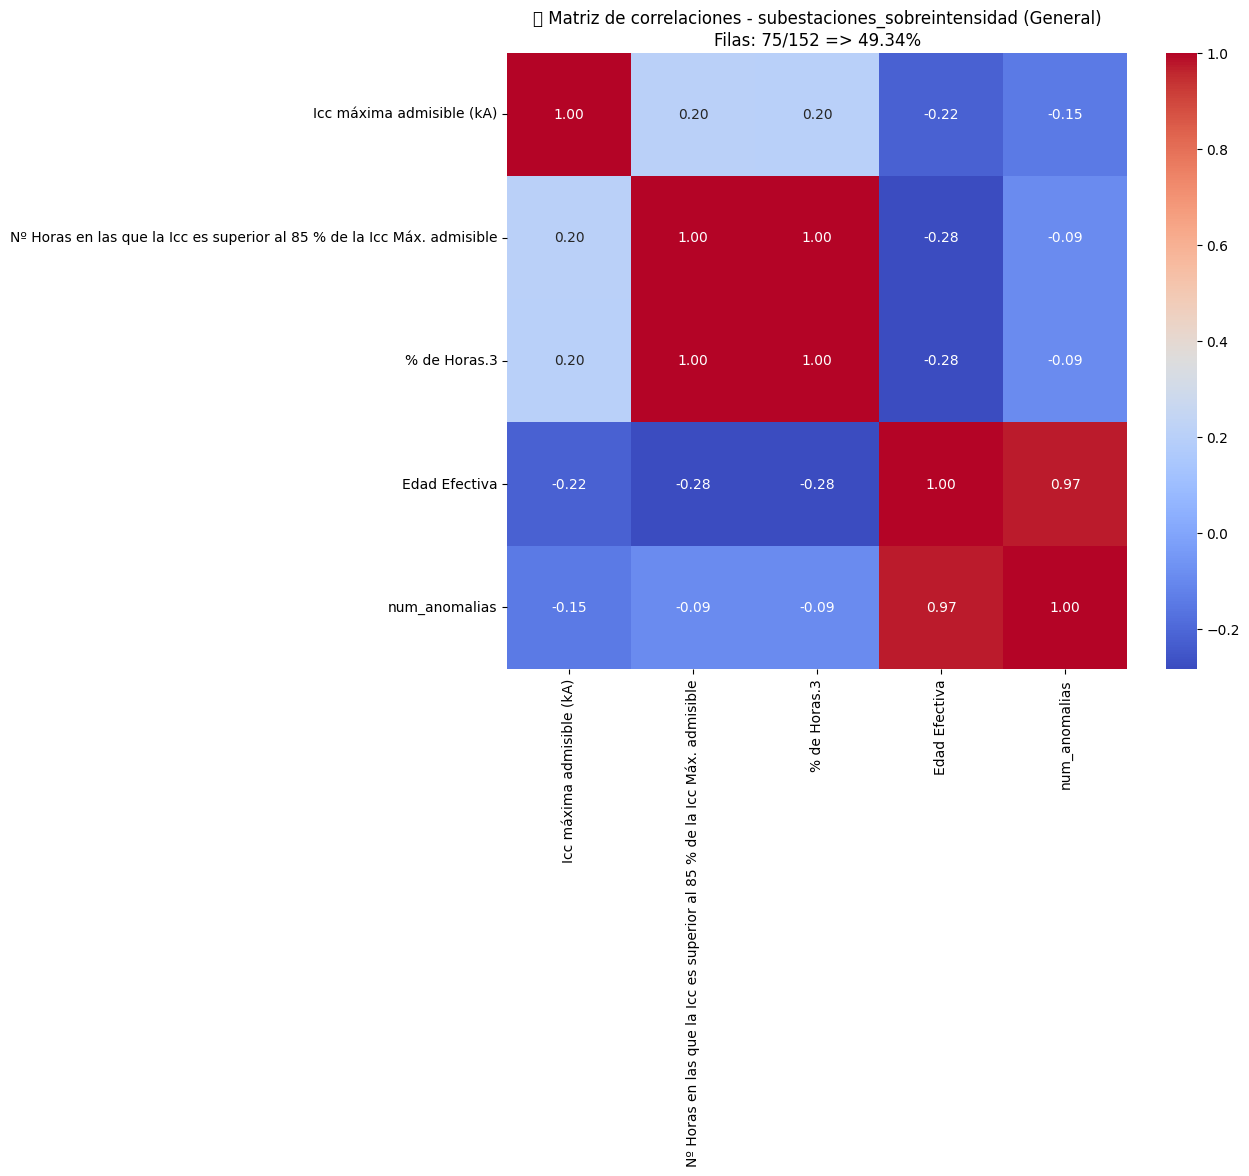

📈 Correlaciones con 'num_anomalias' para subestaciones - subestaciones_sobreintensidad (General):
num_anomalias                                                              1.000000
Edad Efectiva                                                              0.973161
% de Horas.3                                                              -0.089560
Nº Horas en las que la Icc es superior al 85 % de la Icc Máx. admisible   -0.089678
Icc máxima admisible (kA)                                                 -0.146355
Name: num_anomalias, dtype: float64


In [216]:
# Diccionario para almacenar los resultados del análisis
correlation_analysis_results = {}

# Función para procesar DataFrames
def process_dataframe(key, df, original_df, category):
    """Procesar cada DataFrame y realizar el análisis de correlaciones."""
    year = key.split('_')[0]  # Extraer el año del nombre del DataFrame
    print(f"\n🔹 Análisis de correlaciones histórico - {key} ({category})")

    # Calcular porcentaje de filas conservadas
    total_original = len(original_df) if original_df is not None else 0
    total_filled = len(df)
    porcentaje_filled = (total_filled / total_original * 100) if total_original else 0
    print(f" - 📊 Filas en el DataFrame original: {total_original}")
    print(f" - 📊 Filas tras el filtrado: {total_filled}")
    print(f" - 📊 Porcentaje conservado: {porcentaje_filled:.2f}%")

    # Obtener el total correcto del diccionario
    total_referencia = None
    total_general = total_original  # Este debería ser el número total de filas en 'lineas_sobrecarga'
    
    if "lineas_sobrecarga" in key and key in totales_lineas_sobrecarga:
        if category == "Trafo":
            total_referencia = totales_lineas_sobrecarga[key]['trafos']
        elif category == "Circuito":
            total_referencia = totales_lineas_sobrecarga[key]['circuitos']

    # Convertir 'num_anomalias' a número de manera segura
    if 'num_anomalias' in df.columns:
        df['num_anomalias'] = pd.to_numeric(df['num_anomalias'], errors='coerce').fillna(0)

    # Seleccionar columnas numéricas excluyendo 'Año' si está presente
    df_numericas = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Año'], errors='ignore')

    # Eliminar columnas completamente vacías
    df_numericas = df_numericas.dropna(axis=1, how='all')

    if df_numericas.empty:
        print(f"❌ No hay columnas numéricas para analizar en {key} ({category}).")
        return

    # Calcular matriz de correlaciones
    corr_matrix = df_numericas.corr()

    # Visualizar la matriz de correlación con un heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

    # Formatear el título correctamente
    if total_referencia is not None:
        plt.title(f"🔍 Matriz de correlaciones - {key} ({category})\n Filtrado por cod_averia = {filtro_cod_averia}\n Filtrado por cod_causa = {filtro_cod_causa}\n Filtrado por cod_repercusion = {filtro_cod_repercusion}\n Filtrado por grupo_planificador = {filtro_cod_grupo_planificador}\nFilas: {total_filled}/{total_referencia} de {total_general} => {porcentaje_filled:.2f}%")
    else:
        plt.title(f"🔍 Matriz de correlaciones - {key} ({category})\nFilas: {total_filled}/{total_original} => {porcentaje_filled:.2f}%")

    plt.show()

    # Analizar correlaciones con 'num_anomalias'
    if 'num_anomalias' in corr_matrix.columns:
        corr_incidencias = corr_matrix['num_anomalias'].sort_values(ascending=False)
        print(f"📈 Correlaciones con 'num_anomalias' para {year} - {key} ({category}):\n{corr_incidencias}")
        correlation_analysis_results[f"{key}_{category}"] = {'correlations': corr_incidencias, 'num_activos': total_filled}
    else:
        print(f"⚠️ 'num_anomalias' no está presente en {key} ({category}).")

# 🔄 Iterar sobre los DataFrames en el diccionario
for key, df in filtered_dataframes_filled_nuevo.items():
    if any(tipo in key for tipo in ['subestaciones_sobretension', 'lineas_sobrecarga', 'subestaciones_sobreintensidad']):
        original_df = dataframes.get(key, None)  # DataFrame original para cálculo de porcentaje

        # 🚨 Si es 'lineas_sobrecarga', dividir en 'Trafo' y 'Circuito'
        if 'lineas_sobrecarga' in key:
            if 'Código BDI sobrecarga' in df.columns:
                df_trafo = df[df['Código BDI sobrecarga'].astype(str).str.startswith('1')].copy()
                process_dataframe(key, df_trafo, original_df, "Trafo")

                df_circuito = df[df['Código BDI sobrecarga'].astype(str).str.startswith('2')].copy()
                process_dataframe(key, df_circuito, original_df, "Circuito")
            else:
                print(f"⚠️ La columna 'Código BDI sobrecarga' no está presente en {key}.")
        else:
            process_dataframe(key, df, original_df, "General")

In [217]:
print("Columnas en resultado:", resultado.columns)
print("Columnas en df_trafo:", df_trafo.columns)
print("Columnas en df_circuito:", df_circuito.columns)

Columnas en resultado: Index(['cod_aviso', 'Año', 'cod_averia', 'cod_causa', 'cod_repercusion',
       'cod_grupo_planificador', 'Filtro tipos de anomalías'],
      dtype='object')
Columnas en df_trafo: Index(['Códigos PSSE', 'Codificación Oficial.1', 'Código BDI sobrecarga',
       'LÍNEA o ATP', 'Carga media (MVA)', 'Carga media (%)',
       'Nº Horas con Carga Superior al 80 % de su Capacidad de Transporte',
       '% de Horas.1',
       'Nº Horas con Carga Superior al 100 % de su Capacidad de Transporte',
       '% de Horas.2', 'Edad Instalación', 'num_anomalias'],
      dtype='object')
Columnas en df_circuito: Index(['Códigos PSSE', 'Codificación Oficial.1', 'Código BDI sobrecarga',
       'LÍNEA o ATP', 'Carga media (MVA)', 'Carga media (%)',
       'Nº Horas con Carga Superior al 80 % de su Capacidad de Transporte',
       '% de Horas.1',
       'Nº Horas con Carga Superior al 100 % de su Capacidad de Transporte',
       '% de Horas.2', 'Edad Instalación', 'num_anomalias'],
    

In [218]:
df_trafo.head()

,Códigos PSSE,Codificación Oficial.1,Código BDI sobrecarga,LÍNEA o ATP,Carga media (MVA),Carga media (%),Nº Horas con Carga Superior al 80 % de su Capacidad de Transporte,% de Horas.1,Nº Horas con Carga Superior al 100 % de su Capacidad de Transporte,% de Horas.2,Edad Instalación,num_anomalias
0,13024-23103-1,FTD-ATP1,1006:2394,AT-1 400/220 kV FUENDET,123.666667,0.203274,288,0.033345,1,0.000116,NaN,1.0
1,14000-24010-1,ALZ-ATP1,1006:5745,AT-1 400/220 kV ALMARAZ,151.111111,0.331542,160,0.018525,1,0.000116,NaN,1.0
17,12065-22127-2,MUD-ATP2,1006:5375,AT-2 400/220 kV MUDARRA,174.666667,0.279800,59,0.006830,1,0.000116,NaN,0.0
27,1013-11013-1,BME-ATP1,1006:2113,AT-1 400/132 kV BOIMENTE,50.363636,0.113217,296,0.034271,2,0.000232,NaN,1.0
32,11013-41013-1,BME-ATP1,1006:2113,AT-1 400/132 kV BOIMENT,106.000000,0.232800,816,0.095300,2,0.0007,NaN,1.0


In [219]:
df_circuito.head()

,Códigos PSSE,Codificación Oficial.1,Código BDI sobrecarga,LÍNEA o ATP,Carga media (MVA),Carga media (%),Nº Horas con Carga Superior al 80 % de su Capacidad de Transporte,% de Horas.1,Nº Horas con Carga Superior al 100 % de su Capacidad de Transporte,% de Horas.2,Edad Instalación,num_anomalias
2,12017-12060-1,NaN,2003:1192,L-400 kV SENGRAC-LA SERN (1),267.222222,0.260536,93,0.010768,1,0.000116,20.76,0.0
3,22130-22245-1,NaN,2003:186,L-220 kV ORCOYEN-TAFALLA (1),161.200000,0.251139,56,0.006484,1,0.000116,19.01,0.0
4,23325-23330-1,NaN,2003:660,L-220 kV CONSTAN-TARRAGO (1),81.000000,0.322286,34,0.003937,1,0.000116,19.10,0.0
5,22085-22130-1,NaN,2003:723,L-220 kV ICHASO-ORCOYEN (1),33.400000,0.135901,27,0.003126,1,0.000116,65.04,0.0
6,23210-23395-1,NaN,2003:825,L-220 kV PENAFLO-VILLANU (1),42.500000,0.152313,27,0.003126,1,0.000116,36.02,0.0


In [220]:
avisos_bdi.head()

,QMNUM,BDI,Año,cod_averia,cod_causa,cod_repercusion,cod_grupo_planificador,Filtro tipos de anomalías
0,1.000149e+10,2019:2494,2021,F082,NaN,2.0,DML,S
1,1.000149e+10,2019:2495,2021,F082,NaN,2.0,DML,S
2,1.000149e+10,2019:2496,2021,F082,NaN,2.0,DML,S
3,1.000149e+10,2019:1874,2021,F082,NaN,2.0,DML,S
4,1.000149e+10,2019:7927,2021,F082,NaN,2.0,DML,S


BDI del trafo con más anomalías: 1006:1783
BDI del circuito con más anomalías: 2003:1192


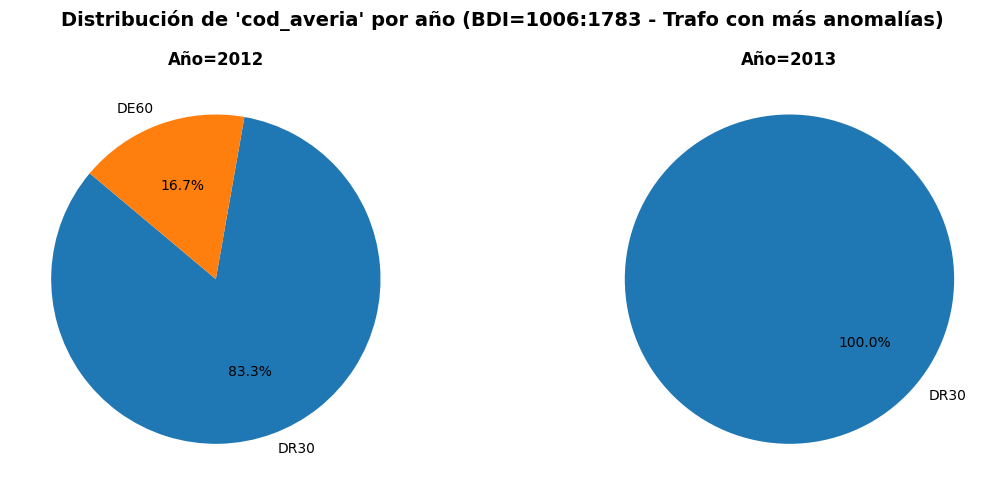

⚠️ No hay años válidos en la columna 'Año'. Se omite el gráfico.


In [221]:
# 1) Hallar trafo y circuito con más num_anomalias
max_trafo_idx = df_trafo["num_anomalias"].idxmax()
max_circuito_idx = df_circuito["num_anomalias"].idxmax()

# 2) Extraer su "Código BDI sobrecarga"
bdi_trafo = df_trafo.loc[max_trafo_idx, "Código BDI sobrecarga"]
bdi_circuito = df_circuito.loc[max_circuito_idx, "Código BDI sobrecarga"]

print(f"BDI del trafo con más anomalías: {bdi_trafo}")
print(f"BDI del circuito con más anomalías: {bdi_circuito}")

# 3) Filtrar avisos_bdi para cada BDI
df_avisos_trafo = avisos_bdi[avisos_bdi["BDI"] == bdi_trafo]
df_avisos_circuito = avisos_bdi[avisos_bdi["BDI"] == bdi_circuito]

# Función para graficar pie-charts de 'cod_averia' por 'Año'
def plot_pies_cod_averia_por_anio(df, titulo):
    """
    Crea un gráfico de tarta para cada año en la columna 'Año',
    mostrando la distribución de 'cod_averia'.
    """
    # Verificamos que existan las columnas necesarias
    if "cod_averia" not in df.columns:
        print("⚠️ El DataFrame no tiene la columna 'cod_averia'. Se omite el gráfico.")
        return
    if "Año" not in df.columns:
        print("⚠️ El DataFrame no tiene la columna 'Año'. Se omite el gráfico.")
        return
    
    # Obtenemos la lista de años únicos (ordenada)
    years = sorted(df["Año"].dropna().unique())
    if len(years) == 0:
        print("⚠️ No hay años válidos en la columna 'Año'. Se omite el gráfico.")
        return
    
    # Creamos un subplot por año (todos en una misma fila)
    fig, axes = plt.subplots(1, len(years), figsize=(6 * len(years), 5))
    if len(years) == 1:
        axes = [axes]  # Si es un único año, convertimos axes en lista
    
    for ax, year in zip(axes, years):
        # Filtramos el df para ese año
        df_year = df[df["Año"] == year]
        # Contamos cuántas filas hay por cada 'cod_averia'
        counts = df_year["cod_averia"].value_counts(dropna=False)
        
        # Gráfico de tarta
        ax.pie(
            counts,
            labels=counts.index,
            autopct="%1.1f%%",
            startangle=140
        )
        ax.set_title(f"Año={year}", fontsize=12, fontweight="bold")

    plt.suptitle(titulo, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


# 4) Dibujar los quesitos:

# 4.a) Para el Trafo
plot_pies_cod_averia_por_anio(
    df_avisos_trafo, 
    f"Distribución de 'cod_averia' por año (BDI={bdi_trafo} - Trafo con más anomalías)"
)

# 4.b) Para el Circuito
plot_pies_cod_averia_por_anio(
    df_avisos_circuito, 
    f"Distribución de 'cod_averia' por año (BDI={bdi_circuito} - Circuito con más anomalías)"
)

BDI del trafo con más anomalías: 1006:1783
BDI del circuito con más anomalías: 2003:1192


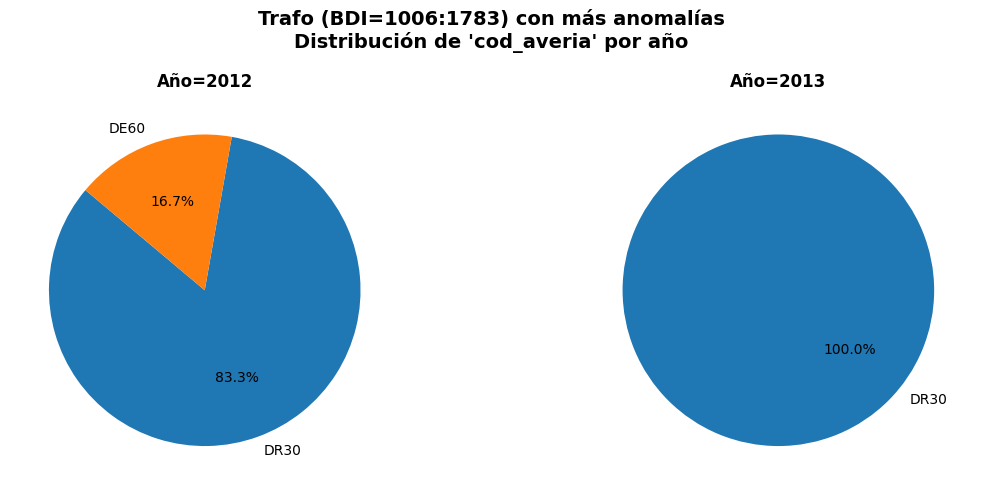

⚠️ No hay años válidos en la columna 'Año'. Se omite el gráfico.


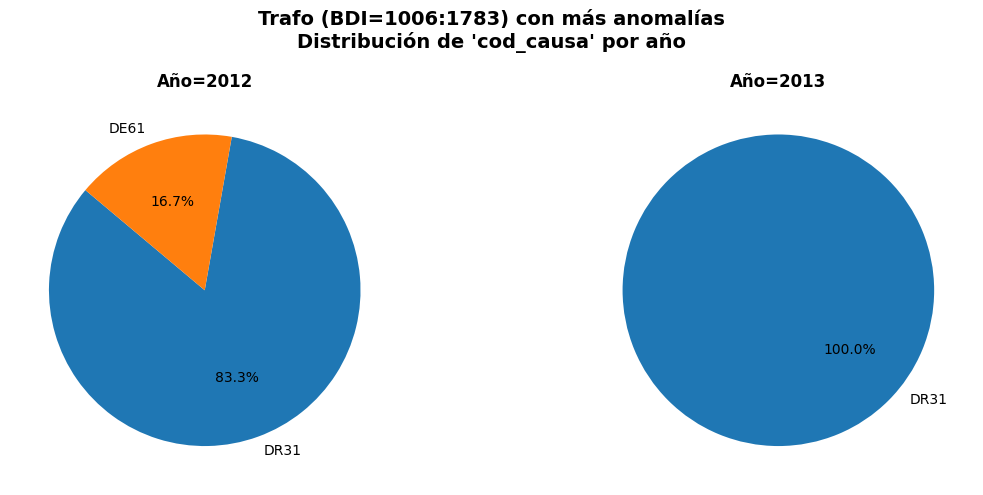

⚠️ No hay años válidos en la columna 'Año'. Se omite el gráfico.


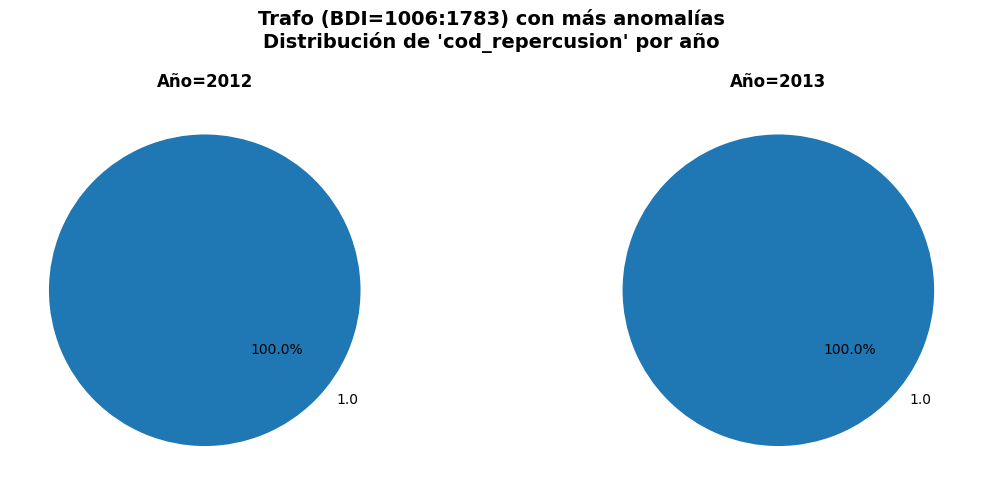

⚠️ No hay años válidos en la columna 'Año'. Se omite el gráfico.


In [222]:
# -- 1) Hallar trafo y circuito con más anomalías
idx_trafo_max = df_trafo["num_anomalias"].idxmax()
idx_circuito_max = df_circuito["num_anomalias"].idxmax()

# -- 2) Extraer su "Código BDI sobrecarga"
bdi_trafo = df_trafo.loc[idx_trafo_max, "Código BDI sobrecarga"]
bdi_circuito = df_circuito.loc[idx_circuito_max, "Código BDI sobrecarga"]

print(f"BDI del trafo con más anomalías: {bdi_trafo}")
print(f"BDI del circuito con más anomalías: {bdi_circuito}")

# -- 3) Filtrar avisos_bdi para cada BDI
df_avisos_trafo = avisos_bdi[avisos_bdi["BDI"] == bdi_trafo]
df_avisos_circuito = avisos_bdi[avisos_bdi["BDI"] == bdi_circuito]

def plot_pies_por_anio(df, columna_objetivo, titulo):
    """
    Crea un gráfico de tarta para cada 'Año' mostrando la distribución de 'columna_objetivo'.
    """
    if columna_objetivo not in df.columns:
        print(f"⚠️ El DataFrame no tiene la columna '{columna_objetivo}'. Se omite el gráfico.")
        return
    if "Año" not in df.columns:
        print("⚠️ El DataFrame no tiene la columna 'Año'. Se omite el gráfico.")
        return

    # Obtenemos la lista de años
    years = sorted(df["Año"].dropna().unique())
    if len(years) == 0:
        print("⚠️ No hay años válidos en la columna 'Año'. Se omite el gráfico.")
        return

    # 1 gráfico de tarta por año, en la misma fila
    fig, axes = plt.subplots(1, len(years), figsize=(6 * len(years), 5))
    if len(years) == 1:
        axes = [axes]  # forzar lista si solo hay un año

    for ax, year in zip(axes, years):
        df_year = df[df["Año"] == year]
        # Contamos cuántas filas hay por cada valor de la columna objetivo
        counts = df_year[columna_objetivo].value_counts(dropna=False)
        
        ax.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=140)
        ax.set_title(f"Año={year}", fontsize=12, fontweight="bold")

    plt.suptitle(f"{titulo}\nDistribución de '{columna_objetivo}' por año", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

# -- 4) Para cada campo (cod_averia, cod_causa, cod_repercusion), 
#       graficamos trafo y circuito

campos = ["cod_averia", "cod_causa", "cod_repercusion"]

for campo in campos:
    # Para el trafo que más anomalías tiene
    plot_pies_por_anio(
        df_avisos_trafo, 
        campo, 
        f"Trafo (BDI={bdi_trafo}) con más anomalías"
    )
    # Para el circuito que más anomalías tiene
    plot_pies_por_anio(
        df_avisos_circuito, 
        campo, 
        f"Circuito (BDI={bdi_circuito}) con más anomalías"
    )